## Stock Price Prediction and Forecasting Using Stacked LSTM

### Stock Data Collection

We will predict the stock price of Apple (APPL) and also forecast for future 30 days. We will be using the `Tiingo Stock & Financial Markets Data API` to download the data.  

In [1]:
import pandas as pd
import pandas_datareader as pdr
data = pdr.get_data_tiingo('AQMS', api_key = input('Enter your API key: '))
data.to_csv('AQMS.csv')
df=pd.read_csv('AQMS.csv')
df.head()

c:\Users\16044\anaconda3\envs\tensorflow\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AQMS,2017-09-21 00:00:00+00:00,5.60,6.000,5.54,5.95,241568,5.60,6.000,5.54,5.95,241568,0.0,1.0
1,AQMS,2017-09-22 00:00:00+00:00,5.49,5.790,5.45,5.60,237041,5.49,5.790,5.45,5.60,237041,0.0,1.0
2,AQMS,2017-09-25 00:00:00+00:00,5.60,5.890,5.49,5.51,230767,5.60,5.890,5.49,5.51,230767,0.0,1.0
3,AQMS,2017-09-26 00:00:00+00:00,5.82,6.400,5.61,5.67,399902,5.82,6.400,5.61,5.67,399902,0.0,1.0
4,AQMS,2017-09-27 00:00:00+00:00,6.05,6.141,5.82,5.86,340310,6.05,6.141,5.82,5.86,340310,0.0,1.0


In [2]:
df1 = df.reset_index()['high']
df1.head()

0    6.000
1    5.790
2    5.890
3    6.400
4    6.141
Name: high, dtype: float64

In [3]:
df1.shape

(1257,)

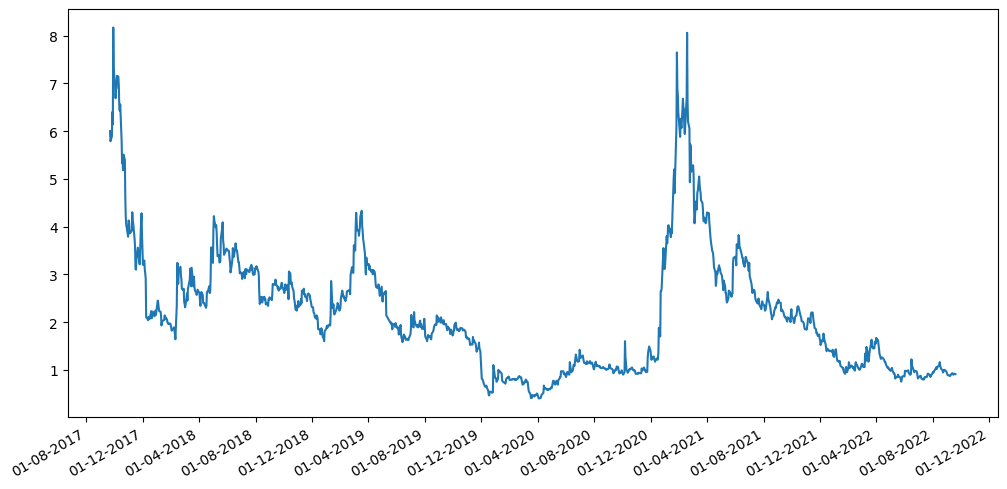

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df['date']), pd.to_numeric(df['high']))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

### Data Preprocessing

`LSTM` models require scaling. We will use the `MinMaxScaler` from `Sci-kit Learn` to scale all the values to be between $0$ and $1$.

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1[:3,:]

c:\Users\16044\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[0.72072072],
       [0.69369369],
       [0.70656371]])

There are various ways to split the data into training and testing set, e.g. `Cross Validation`, `Random Seed`, etc. But with time-series data these methods are not going to work. Let us take the value at date $n$ to be $x_n$. For a time-series data like stock prices it is assumed that $x_n$ is dependent on $x_{n-1}, x_{n-2}, \dots, x_{n-m}$. So, for the training we can take the first $70\%$ of the dates and take the rest for testing. Note that the data in its current form is not trainable. We need to convert the data so that we have $m$ features (timesteps) which determines $x_n$ and these $m$ featues (timesteps) are nothing but $x_{n-1}, x_{n-2}, \dots, x_{n-m}$. The hyperparameter $m$ can be tuned. We take it to be 100 for this analysis.

In [6]:
#Split the data into train and test
train_size = int(len(df1)*0.65)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size, :], df1[train_size:, :]
print(train_data[:3, :])
print(test_data[:3, :])

[[0.72072072]
 [0.69369369]
 [0.70656371]]
[[0.19047619]
 [0.16731017]
 [0.28957529]]


In [7]:
def create_dataset(dataset, timesteps=10):
    ''' Create dataset with features for training. 
    inputs: dataset : np.array
            timesteps : int. This is the number of features. Default is 10 
    
    returns: np.array X, np.array y
    '''
    X, y = [], []
    for i in range(len(dataset)-timesteps-1):
        X.append(dataset[i:i+timesteps, 0])
        y.append(dataset[i+timesteps, 0])
    
    return np.array(X), np.array(y)

In [9]:
timesteps = 150
X_train, y_train = create_dataset(train_data, timesteps)
X_test, y_test = create_dataset(test_data, timesteps)

In [10]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(666, 150) (666,) (289, 150) (289,)


In [11]:
#reshape the input to be [batch, timesteps, feature]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Create the LSTM model

In [12]:
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.9.1', '2.9.0')

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=1e-3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 150, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 1e-6, patience=10)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=2)

Epoch 1/100
11/11 - 21s - loss: 0.0145 - val_loss: 9.2914e-04 - 21s/epoch - 2s/step
Epoch 2/100
11/11 - 7s - loss: 0.0038 - val_loss: 0.0026 - 7s/epoch - 669ms/step
Epoch 3/100
11/11 - 7s - loss: 0.0021 - val_loss: 4.5709e-04 - 7s/epoch - 673ms/step
Epoch 4/100
11/11 - 7s - loss: 0.0018 - val_loss: 4.9612e-04 - 7s/epoch - 649ms/step
Epoch 5/100
11/11 - 7s - loss: 0.0017 - val_loss: 5.0463e-04 - 7s/epoch - 649ms/step
Epoch 6/100
11/11 - 7s - loss: 0.0015 - val_loss: 5.3363e-04 - 7s/epoch - 636ms/step
Epoch 7/100
11/11 - 7s - loss: 0.0015 - val_loss: 5.6736e-04 - 7s/epoch - 658ms/step
Epoch 8/100
11/11 - 7s - loss: 0.0015 - val_loss: 4.3548e-04 - 7s/epoch - 652ms/step
Epoch 9/100
11/11 - 7s - loss: 0.0013 - val_loss: 3.9433e-04 - 7s/epoch - 630ms/step
Epoch 10/100
11/11 - 7s - loss: 0.0013 - val_loss: 4.2887e-04 - 7s/epoch - 630ms/step
Epoch 11/100
11/11 - 7s - loss: 0.0014 - val_loss: 4.0698e-04 - 7s/epoch - 670ms/step
Epoch 12/100
11/11 - 7s - loss: 0.0013 - val_loss: 3.7291e-04 - 7s/e

In [18]:
train_pred_frac = model.predict(X_train)
test_pred_frac = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred_frac)
test_pred = scaler.inverse_transform(test_pred_frac)

import math
from sklearn.metrics import mean_squared_error
print('train_error: ', math.sqrt(mean_squared_error(y_train, train_pred)))
print('test_error: ', math.sqrt(mean_squared_error(y_test, test_pred)))

10/10 [==============================] - 1s 98ms/step
train_error:  1.892743631283759
test_error:  1.4055208898094071


### Plotting the Predictions

In [19]:
len(train_pred)

666

In [20]:
(len(df1)-1) - (len(train_pred) + 2*timesteps + 1) == len(test_pred)

True

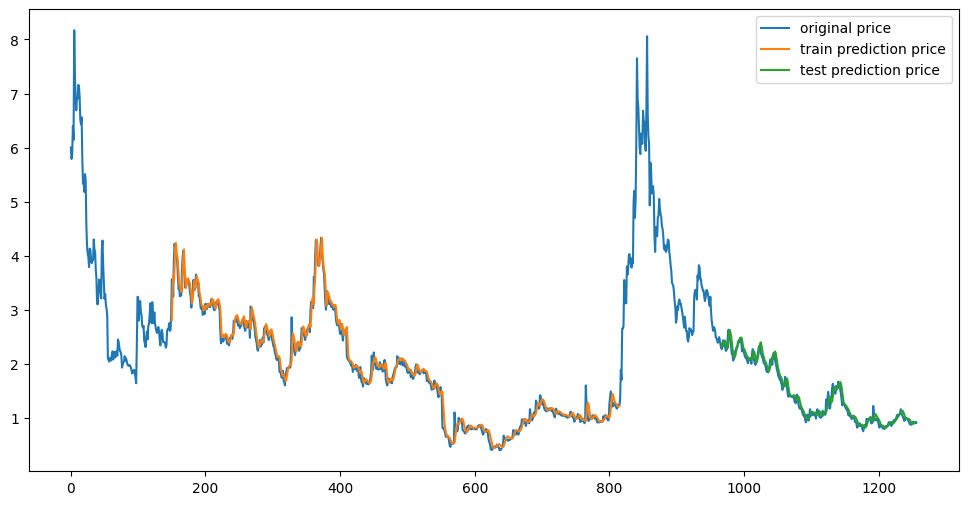

In [21]:
# Shift train predictions for plotting
look_back = timesteps              #this is same as timesteps. We need to plot from the 100th index as the first prediction is after 100 days
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = train_pred

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+2*look_back+1:len(df1)-1, :] = test_pred
# plot all the predictions 
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(scaler.inverse_transform(df1), label = 'original price')
ax.plot(trainPredictPlot, label = 'train prediction price')
ax.plot(testPredictPlot, label = 'test prediction price')
ax.legend()
plt.show()

### Forecast for the Future

In [22]:
x_input = test_data[len(test_data)-timesteps : ].reshape(1,-1)
x_input.shape

(1, 150)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
len(temp_input)

150

In [29]:
lst_output=[]
n_steps=150
i=0
while(i<50):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=np.array(temp_input[0:])
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.06807126849889755], [0.06857304275035858], [0.0692894235253334], [0.0701175406575203], [0.07099562138319016], [0.0718950405716896], [0.07280392944812775], [0.07371730357408524], [0.07463262230157852], [0.07554832100868225], [0.07646328210830688], [0.0773768424987793], [0.07828860729932785], [0.07919850945472717], [0.08010665327310562], [0.08101329207420349], [0.0819188579916954], [0.08282383531332016], [0.08372867852449417], [0.084633968770504], [0.08554023504257202], [0.08644799888134003], [0.08735775947570801], [0.08827002346515656], [0.0891852080821991], [0.09010371565818787], [0.0910259485244751], [0.09195227921009064], [0.09288299083709717], [0.09381844848394394], [0.09475884586572647], [0.09570450335741043], [0.09665568172931671], [0.0976126417517662], [0.09857553988695145], [0.09954473376274109], [0.10052035748958588], [0.10150273889303207], [0.1024920865893364], [0.10348870605230331], [0.10449279844760895], [0.10550469905138016], [0.10652468353509903], [0.10755307227373123]

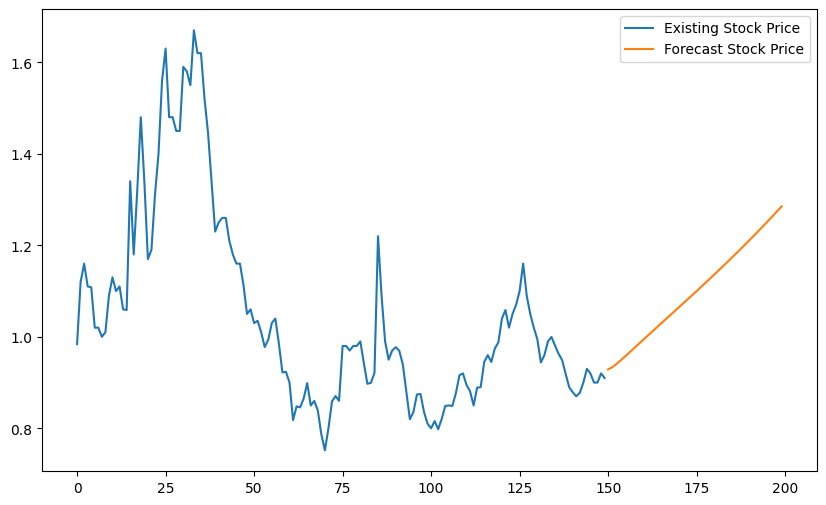

In [32]:
day_new=np.arange(timesteps)
day_pred=np.arange(timesteps,timesteps+50)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(day_new,scaler.inverse_transform(df1[len(df1)-150:]), label = 'Existing Stock Price')
ax.plot(day_pred,scaler.inverse_transform(lst_output), label = 'Forecast Stock Price')
ax.legend()
plt.show()